In [1]:
import datetime
import numpy as np
import pandas as pd

In [2]:
def consolidate_df(shorter, longer, window, grid_mul, grid_num, ref = 'SMA'):
    '''
    manipulate the 1-min and 15min data for backtesting
    input should be str for the path of the data
    '''
    ref = ref.lower()

    if shorter[-4:] == 'xlsx':
        shorter_df = pd.read_excel(shorter)
    elif shorter[-3:] == 'csv':
        shorter_df = pd.read_csv(shorter)
        shorter_df['Dates'] = pd.to_datetime(shorter_df['Dates'])

    if longer[-4:] == 'xlsx':
        longer_df = pd.read_excel(longer)
    elif longer[-3:] == 'csv':
        longer_df = pd.read_csv(longer)
        longer_df['Dates'] = pd.to_datetime(longer_df['Dates'])

    #only keep close
    shorter_df = shorter_df[['Dates', 'Close']]
    longer_df = longer_df[['Dates', 'Close', 'LSTM', 'ARIMA']]

    # shift so we cant look into the future
    longer_df['Close'] = longer_df['Close'].shift()
    longer_df['LSTM'] = longer_df['LSTM'].shift()
    longer_df['ARIMA'] = longer_df['ARIMA'].shift()


    # rolling standard deviation
    longer_df['roll_std'] = longer_df['Close'].rolling(window).std()

    # roll mean will be our ref
    if ref == 'sma':
        longer_df['roll_mean'] = longer_df['Close'].rolling(window).mean()
    elif ref == 'lstm':
        longer_df['roll_mean'] = longer_df['LSTM']
    elif ref == 'arima':
        longer_df['roll_mean'] = longer_df['ARIMA']
    else:
        print('not supported')
        return None

    # Grid
    longer_df[f'grid({grid_num})'] = longer_df['roll_mean'] +  grid_mul * longer_df['roll_std']
    longer_df[f'grid({-grid_num})'] = longer_df['roll_mean'] -  grid_mul * longer_df['roll_std']
    for i in range(1, grid_num):
        longer_df[f'grid({i})'] = longer_df['roll_mean'] + i/grid_num * (longer_df[f'grid({grid_num})'] - longer_df['roll_mean'])
        longer_df[f'grid({-i})'] = longer_df['roll_mean'] - i/grid_num * (longer_df['roll_mean'] - longer_df[f'grid({-grid_num})'])

    # merge and return
    shorter_df.rename(columns={'Close':'1min'}, inplace=True)
    longer_df.rename(columns={'Close':'15min'}, inplace=True)

    return pd.merge_asof(shorter_df, longer_df.sort_values('Dates'), on='Dates')

In [3]:
# params set
window = 20
grid_mul = 3
grid_num = 5
slippage = 0.00002 #0.1bp
brokerage = 0 #in dollar

In [13]:
shorter = 'AUD_1min.xlsx'
longer = 'AUD_Final.xlsx'
# ['AAPL_1min.xlsx','AUD_1min.xlsx','CAD_1min.xlsx']
# ['AAPL_15min.xlsx','AUD_15min.xlsx','CAD_15min.xlsx']
# ['AAPL-forecasted price-15min of 1M.xlsx', 'AUD-forecasted price-15min of 1M.xlsx', 'CAD-forecasted price-15min of 1M']
# ['AUD_Final.xlsx', 'CAD_Final.xlsx', 'AAPL_Final.xlsx']
df = consolidate_df(shorter, longer, window, grid_mul, grid_num, ref = 'ARIMA')
pd.set_option('display.precision',  8)
# df.head(20)

In [5]:
def apply_strat(df, grid_num, stop_period = 20):
    '''
    better buy sell signal generation 
    more well defined strat and not hardcoded
    '''
    df['signal'] = 1
    stop_trigger = 0

    for i in range(len(df)):
        # if price breaks out of range, we need to stop til stop_period
        if stop_trigger:
            df.loc[i, 'signal'] = 0
            stop_trigger = (stop_trigger + 1) % stop_period
        else:
            # price is ard our mid price
            if df.loc[i, 'grid(-1)'] < df.loc[i, '1min'] <= df.loc[i, 'grid(1)']:
                df.loc[i, 'signal'] = 0
            #price is out of our upper and lower limit
            elif df.loc[i, f'grid({grid_num})'] < df.loc[i, '1min'] or df.loc[i, '1min'] <= df.loc[i, f'grid({-grid_num})']:
                df.loc[i, 'signal'] = 0
                stop_trigger = 1
            else:
                for j in range(1, grid_num):
                    # price falls in positive grid j
                    if df.loc[i, f'grid({j})'] < df.loc[i, '1min'] <= df.loc[i, f'grid({j + 1})']:
                        df.loc[i, 'signal'] = -j
                    # negative grid
                    elif (df.loc[i, f'grid({-j - 1})'] < df.loc[i, '1min'] <= df.loc[i, f'grid({-j})']):
                        df.loc[i, 'signal'] = j

    
    df['B/S'] = df['signal'].diff().fillna(df['signal'])
    return df

def backtest_result(df, grid_num = 5 , brokerage = 1, slippage = 0.00002 / 2, amount = 100000):
    '''
    compare signals to calculate profit
    '''
    df['quantity'] = round(amount * df['B/S'] / df['1min'] / (grid_num - 1), 0)

    df['position'] = 0
    df.loc[0,'position'] = df.loc[0,'quantity']
    for i in range(1, len(df)):
        df.loc[i,'position'] = df.loc[i - 1,'position'] + df.loc[i,'quantity']

    df['notional'] = -df['quantity'] * df['1min']

    df['cum_notional'] = 0
    df.loc[0,'cum_notional'] = df.loc[0,'notional']
    for i in range(1, len(df)):
        df.loc[i,'cum_notional'] = df.loc[i - 1,'cum_notional'] + df.loc[i,'notional']

    df['PnL'] = df['cum_notional'] + df['position'] * df['1min']
    df['1minPnL'] = df['PnL'].diff().fillna(0)
    df['brokerage'] = (df['B/S'] != 0 ) * brokerage
    df['slippage'] = abs(df['notional']) * slippage
    df['net_PnL'] = df['PnL'] - df['slippage'].cumsum() - df['brokerage'].cumsum()
    df['net_1minPnL'] = df['net_PnL'].diff().fillna(0)
    return df

In [14]:
df = apply_strat(df, grid_num, 30)

In [15]:
df = backtest_result(df, grid_num, brokerage, slippage, 100000)
pd.set_option('display.precision',  4)
df.head(30)

,Dates,1min,15min,LSTM,ARIMA,roll_std,roll_mean,grid(5),grid(-5),grid(1),...,quantity,position,notional,cum_notional,PnL,1minPnL,brokerage,slippage,net_PnL,net_1minPnL
0,2023-03-01 09:00:00,0.6756,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000
1,2023-03-01 09:01:00,0.6759,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000
2,2023-03-01 09:02:00,0.6758,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000
3,2023-03-01 09:03:00,0.6756,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000
4,2023-03-01 09:04:00,0.6756,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000
5,2023-03-01 09:05:00,0.6754,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000
6,2023-03-01 09:06:00,0.6754,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000
7,2023-03-01 09:07:00,0.6753,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000
8,2023-03-01 09:08:00,0.6753,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000
9,2023-03-01 09:09:00,0.6754,0.6755,0.6758,0.6756,0.0008,0.6756,0.6780,0.6732,0.6761,...,0.0,0,-0.0000,0.0000,0.0000,0.0000,0,0.0,0.0000,0.0000


In [16]:
# some key stats
def key_stat(df):
    res = {}
    res['Gross Profit'] = df.loc[len(df) - 1,'PnL']
    # res['num_of_trade'] = len(df[df['B/S'] != 0])
    res['1-min Rtn Mean'] = df['1minPnL'].mean()
    res['1-min Rtn Std'] = df['1minPnL'].std()
    res['1-min Sharpe'] = df['1minPnL'].mean() / df['1minPnL'].std()
    res['Trans_cost'] = df['brokerage'].sum() + df['slippage'].sum()
    res['Net Profit'] = df.loc[len(df) - 1,'net_PnL']
    return res

res = key_stat(df)
res

{'Gross Profit': 4098.666599999956,
 '1-min Rtn Mean': 0.12446603704828291,
 '1-min Rtn Std': 6.037879091232524,
 '1-min Sharpe': 0.020614198324874936,
 'Trans_cost': 2845.0016313059996,
 'Net Profit': 1253.664968693975}

In [9]:
# store PnL for plot
# could put this into a loop for better readability
temp = df['PnL']

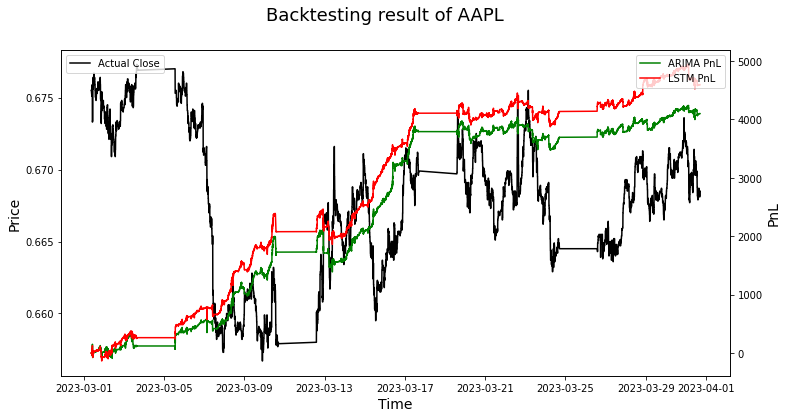

In [17]:
#plot
import matplotlib.pyplot as plt
plot_df = df[['Dates', '1min', '15min', 'LSTM', 'ARIMA', 'PnL']]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.set_xlabel('Time', fontsize=14)
ax1.set_ylabel('Price', fontsize=14)
ax1.plot(plot_df['Dates'], plot_df['15min'], color = 'black', label = 'Actual Close')
# ax1.plot(plot_df['Dates'], plot_df['LSTM'], color = 'blue', label = 'LSTM Close')
# ax1.plot(plot_df['Dates'], plot_df['ARIMA'], color = 'orange', label = 'ARIMA Close')
ax1.legend(loc='upper left')

ax2.set_ylabel('PnL', fontsize=14)
ax2.plot(plot_df['Dates'], plot_df['PnL'], color = 'green', label = 'ARIMA PnL')
ax2.plot(plot_df['Dates'], temp, color = 'red', label = 'LSTM PnL')
ax2.legend(loc='upper right')

fig.suptitle("Backtesting result of AAPL", fontsize=18)
fig.set_facecolor(color='white')

<AxesSubplot:xlabel='Dates'>

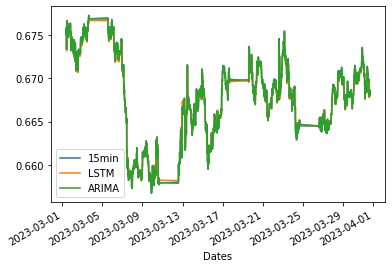

In [11]:
plot_df.plot('Dates', ['15min', 'LSTM', 'ARIMA'])


In [12]:
for_present = pd.DataFrame(res, index=[0])
for_present.T.to_clipboard()